# Clssification of toxic comments 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
import seaborn as sns
#sns.set(style = 'white')
import nltk
#import string
from textblob import TextBlob
import string
import re
from tqdm.auto import tqdm
from bs4 import BeautifulSoup
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 100)

In [2]:
import transformers
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification,\
                              AdamW, get_linear_schedule_with_warmup, DistilBertConfig
import torch
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import tensorflow as tf
import datasets 

RANDOM_SEED = 331
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

#https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

In [3]:
#df=pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
df=pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv')
#test_df=pd.read_csv('../input/jigsaw-toxic-severity-rating/comments_to_score.csv')

In [12]:
df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
47604,7f2cab91dd44d597,"""\n\n \nMONGO, tell us. WHY DID YOU DO WTC? Why MONGO? MONGO, tell us. WHY DID YOU DO WTC? Why...",1,0,0,0,0,0
98579,0f4f08ea91def8b0,"Hillsong\n\nFirst of all, I have no idea who you are, pal. Probably some BOSSY person who thinks...",0,0,0,0,0,0
51003,8867ee6de98787d6,REDIRECT Talk:Georgia State Route 25 Spur (Woodbine),0,0,0,0,0,0
96586,049474966a63c708,"""\n\nThe article states that """"Montenegrin and Serb identities are not exclusive"""", but this is ...",0,0,0,0,0,0
83728,e0174bce737aa565,Thanks for image help,0,0,0,0,0,0


There is six targets to be predicted: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

We can create one multi-label-classification model or six binary-classification models.

In [15]:
df.toxic.value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

# Target analysis

Here we will analyse the distribution of data on each target

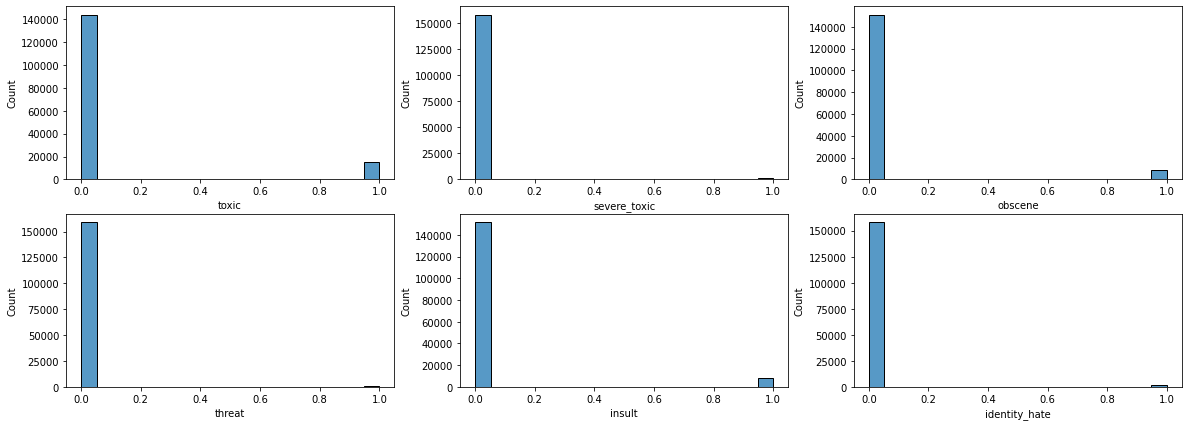

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(20, 7))

sns.histplot(data=df, x="toxic", ax=axs[0, 0])
sns.histplot(data=df, x="severe_toxic",ax=axs[0, 1])
sns.histplot(data=df, x="obscene", ax=axs[0, 2])
sns.histplot(data=df, x="threat", ax=axs[1, 0])
sns.histplot(data=df, x="insult", ax=axs[1, 1])
sns.histplot(data=df, x="identity_hate", ax=axs[1, 2])

plt.show()


We observe that the positive values are very minor.

Next, we will try to balance the data wrt the 'toxic target.

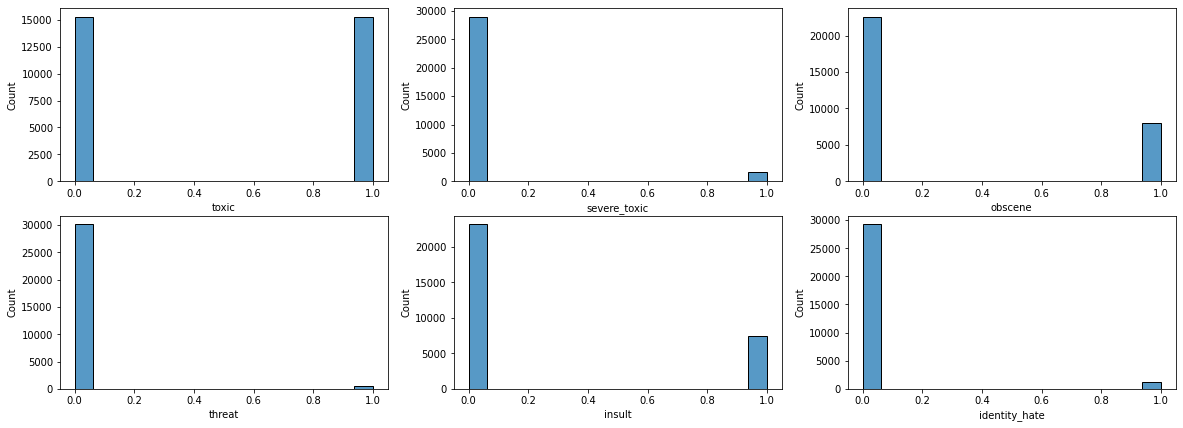

In [17]:
df0=pd.concat([df[(df.toxic==1)],
              df[(df.toxic==0)].sample(15294)
             ])

fig, axs = plt.subplots(2, 3, figsize=(20, 7))

sns.histplot(data=df0, x="toxic", ax=axs[0, 0])
sns.histplot(data=df0, x="severe_toxic",ax=axs[0, 1])
sns.histplot(data=df0, x="obscene", ax=axs[0, 2])
sns.histplot(data=df0, x="threat", ax=axs[1, 0])
sns.histplot(data=df0, x="insult", ax=axs[1, 1])
sns.histplot(data=df0, x="identity_hate", ax=axs[1, 2])

plt.show()

Even if the data is balanced wrt 'toxic' target, but still imbalanced in all the other targets.

We can perform multi balancing on all the targets but we will have less data.

This problem can affect the multi-label-classifier performance, so we will create a separate binary model for each target.

## Text analysis

We will count the number of tokens and plot the histogram of the comment lengths.

<AxesSubplot:xlabel='len_tokenized_sents', ylabel='Count'>

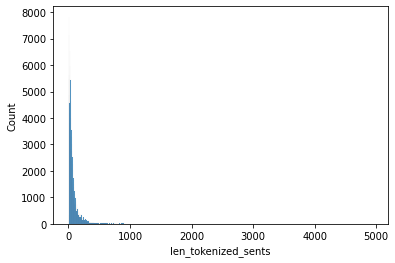

In [20]:
from nltk import word_tokenize

df['len_tokenized_sents'] = df.apply(lambda row: len(word_tokenize(row['comment_text'])), axis=1)
sns.histplot(data=df, x="len_tokenized_sents")

In [22]:
df["comment_text"][np.argmax(df['len_tokenized_sents'])]

'YOU!\nYou blocked me worm why!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

on comment in this data can achieve 5000 tokens, the comment above is one example. So those comment texts needs to be processed.

# Text preprocessing

We summerise the text processing in the following:
* Removing non informative texts (links, html tags, emoticons ...)
* Remove special characters
* Remove extra spaces
* separate between words with space
* Replace the abreviated sentences with the complete sentences

In [4]:
def text_cleaning(text):
    template = re.compile(r'https?://\S+|www\.\S+') #Removes website links
    text = template.sub(r'', text)

    soup = BeautifulSoup(text, 'lxml') #Removes HTML tags
    only_text = soup.get_text()
    text = only_text

    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    text = re.sub(r"[^a-zA-Z\d]", " ", text) #Remove special Charecters
    text = re.sub(' +', ' ', text) #Remove Extra Spaces
    text = text.strip() # remove spaces at the beginning and at the end of string

    return text


def clean(data, col):
    
    data[col] = data[col].str.replace('https?://\S+|www\.\S+', ' social medium ', regex=True)      
        
    data[col] = data[col].str.lower()
    data[col] = data[col].str.replace("4", "a") 
    data[col] = data[col].str.replace("2", "l")
    data[col] = data[col].str.replace("5", "s") 
    data[col] = data[col].str.replace("1", "i") 
    data[col] = data[col].str.replace("!", "i") 
    data[col] = data[col].str.replace("|", "i", regex=False) 
    data[col] = data[col].str.replace("0", "o") 
    data[col] = data[col].str.replace("l3", "b") 
    data[col] = data[col].str.replace("7", "t") 
    data[col] = data[col].str.replace("7", "+") 
    data[col] = data[col].str.replace("8", "ate") 
    data[col] = data[col].str.replace("3", "e") 
    data[col] = data[col].str.replace("9", "g")
    data[col] = data[col].str.replace("6", "g")
    data[col] = data[col].str.replace("@", "a")
    data[col] = data[col].str.replace("$", "s", regex=False)
    data[col] = data[col].str.replace("#ofc", " of fuckin course ")
    data[col] = data[col].str.replace("fggt", " faggot ")
    data[col] = data[col].str.replace("your", " your ")
    data[col] = data[col].str.replace("self", " self ")
    data[col] = data[col].str.replace("cuntbag", " cunt bag ")
    data[col] = data[col].str.replace("fartchina", " fart china ")    
    data[col] = data[col].str.replace("youi", " you i ")
    data[col] = data[col].str.replace("cunti", " cunt i ")
    data[col] = data[col].str.replace("sucki", " suck i ")
    data[col] = data[col].str.replace("pagedelete", " page delete ")
    data[col] = data[col].str.replace("cuntsi", " cuntsi ")
    data[col] = data[col].str.replace("i'm", " i am ")
    data[col] = data[col].str.replace("offuck", " of fuck ")
    data[col] = data[col].str.replace("centraliststupid", " central ist stupid ")
    data[col] = data[col].str.replace("hitleri", " hitler i ")
    data[col] = data[col].str.replace("i've", " i have ")
    data[col] = data[col].str.replace("i'll", " sick ")
    data[col] = data[col].str.replace("fuck", " fuck ")
    data[col] = data[col].str.replace("f u c k", " fuck ")
    data[col] = data[col].str.replace("shit", " shit ")
    data[col] = data[col].str.replace("bunksteve", " bunk steve ")
    data[col] = data[col].str.replace('wikipedia', ' social medium ')
    data[col] = data[col].str.replace("faggot", " faggot ")
    data[col] = data[col].str.replace("delanoy", " delanoy ")
    data[col] = data[col].str.replace("jewish", " jewish ")
    data[col] = data[col].str.replace("sexsex", " sex ")
    data[col] = data[col].str.replace("allii", " all ii ")
    data[col] = data[col].str.replace("i'd", " i had ")
    data[col] = data[col].str.replace("'s", " is ")
    data[col] = data[col].str.replace("youbollocks", " you bollocks ")
    data[col] = data[col].str.replace("dick", " dick ")
    data[col] = data[col].str.replace("cuntsi", " cuntsi ")
    data[col] = data[col].str.replace("mothjer", " mother ")
    data[col] = data[col].str.replace("cuntfranks", " cunt ")
    data[col] = data[col].str.replace("ullmann", " jewish ")
    data[col] = data[col].str.replace("mr.", " mister ", regex=False)
    data[col] = data[col].str.replace("aidsaids", " aids ")
    data[col] = data[col].str.replace("njgw", " nigger ")
    data[col] = data[col].str.replace("wiki", " social medium ")
    data[col] = data[col].str.replace("administrator", " admin ")
    data[col] = data[col].str.replace("gamaliel", " jewish ")
    data[col] = data[col].str.replace("rvv", " vanadalism ")
    data[col] = data[col].str.replace("admins", " admin ")
    data[col] = data[col].str.replace("pensnsnniensnsn", " penis ")
    data[col] = data[col].str.replace("pneis", " penis ")
    data[col] = data[col].str.replace("pennnis", " penis ")
    data[col] = data[col].str.replace("pov.", " point of view ", regex=False)
    data[col] = data[col].str.replace("vandalising", " vandalism ")
    data[col] = data[col].str.replace("cock", " dick ")
    data[col] = data[col].str.replace("asshole", " asshole ")
    data[col] = data[col].str.replace("youi", " you ")
    data[col] = data[col].str.replace("afd", " all fucking day ")
    data[col] = data[col].str.replace("sockpuppets", " sockpuppetry ")
    data[col] = data[col].str.replace("iiprick", " iprick ")
    data[col] = data[col].str.replace("penisi", " penis ")
    data[col] = data[col].str.replace("warrior", " warrior ")
    data[col] = data[col].str.replace("loil", " laughing out insanely loud ")
    data[col] = data[col].str.replace("vandalise", " vanadalism ")
    data[col] = data[col].str.replace("helli", " helli ")
    data[col] = data[col].str.replace("lunchablesi", " lunchablesi ")
    data[col] = data[col].str.replace("special", " special ")
    data[col] = data[col].str.replace("ilol", " i lol ")
    data[col] = data[col].str.replace(r'\b[uU]\b', 'you', regex=True)
    data[col] = data[col].str.replace(r"what's", "what is ")
    data[col] = data[col].str.replace(r"\'s", " is ", regex=False)
    data[col] = data[col].str.replace(r"\'ve", " have ", regex=False)
    data[col] = data[col].str.replace(r"can't", "cannot ")
    data[col] = data[col].str.replace(r"n't", " not ")
    data[col] = data[col].str.replace(r"i'm", "i am ")
    data[col] = data[col].str.replace(r"\'re", " are ", regex=False)
    data[col] = data[col].str.replace(r"\'d", " would ", regex=False)
    data[col] = data[col].str.replace(r"\'ll", " will ", regex=False)
    data[col] = data[col].str.replace(r"\'scuse", " excuse ", regex=False)
    data[col] = data[col].str.replace('\s+', ' ', regex=True)  # will remove more than one whitespace character
#     text = re.sub(r'\b([^\W\d_]+)(\s+\1)+\b', r'\1', re.sub(r'\W+', ' ', text).strip(), flags=re.I)  # remove repeating words coming immediately one after another
    data[col] = data[col].str.replace(r'(.)\1+', r'\1\1', regex=True) # 2 or more characters are replaced by 2 characters
#     text = re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', text, flags = re.I)
    data[col] = data[col].str.replace("[:|♣|'|§|♠|*|/|?|=|%|&|-|#|•|~|^|>|<|►|_]", '', regex=True)
    
    
    data[col] = data[col].str.replace(r"what's", "what is ")    
    data[col] = data[col].str.replace(r"\'ve", " have ", regex=False)
    data[col] = data[col].str.replace(r"can't", "cannot ")
    data[col] = data[col].str.replace(r"n't", " not ", regex=False)
    data[col] = data[col].str.replace(r"i'm", "i am ", regex=False)
    data[col] = data[col].str.replace(r"\'re", " are ", regex=False)
    data[col] = data[col].str.replace(r"\'d", " would ", regex=False)
    data[col] = data[col].str.replace(r"\'ll", " will ", regex=False)
    data[col] = data[col].str.replace(r"\'scuse", " excuse ", regex=False)
    data[col] = data[col].str.replace(r"\'s", " ", regex=False)

    # Clean some punctutations
    data[col] = data[col].str.replace('\n', ' \n ')
    data[col] = data[col].str.replace(r'([a-zA-Z]+)([/!?.])([a-zA-Z]+)',r'\1 \2 \3', regex=True)
    # Replace repeating characters more than 3 times to length of 3
    data[col] = data[col].str.replace(r'([*!?\'])\1\1{2,}',r'\1\1\1', regex=True)    
    # Add space around repeating characters
    data[col] = data[col].str.replace(r'([*!?\']+)',r' \1 ', regex=True)    
    # patterns with repeating characters 
    data[col] = data[col].str.replace(r'([a-zA-Z])\1{2,}\b',r'\1\1', regex=True)
    data[col] = data[col].str.replace(r'([a-zA-Z])\1\1{2,}\B',r'\1\1\1', regex=True)
    data[col] = data[col].str.replace(r'[ ]{2,}',' ', regex=True).str.strip()   
    data[col] = data[col].str.replace(r'[ ]{2,}',' ', regex=True).str.strip()   
    tqdm.pandas()
    data[col] = data[col].progress_apply(text_cleaning)
    data[col] = data[col].apply(lambda x: x.lower())
    return data

In [5]:
#test_df=clean(test_df,'text')
df=clean(df, 'comment_text')

  0%|          | 0/159571 [00:00<?, ?it/s]

<AxesSubplot:xlabel='len_tokenized_sents', ylabel='Count'>

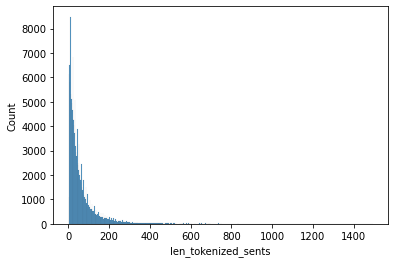

In [25]:
df['len_tokenized_sents'] = df.apply(lambda row: len(word_tokenize(row['comment_text'])), axis=1)
sns.histplot(data=df, x="len_tokenized_sents")

In [26]:
df["comment_text"][np.argmax(df['len_tokenized_sents'])]

'fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you i fuck you 

In [29]:
len(df[df['len_tokenized_sents']>200])/len(df)

0.06572622845003165

Now, the comments with lengths more than 200 represents only 6%

# prepare data for training

For each target we will balance the dataset and split it into train,valid,test. Then we tokenize the comments with bert tokenizer (because we will use bert later in classification).

Here we will show only the prosses for 'toxic' target, and we can do the same process for the other targets.

In [6]:
df=pd.concat([df[(df.toxic==1)],
              df[(df.toxic==0)].sample(15294)
             ])
df['target']=df['toxic']

df.reset_index(inplace=True)
df_train, df_valid = train_test_split(df, test_size=0.1, random_state=42)
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=42)

train_ds = datasets.Dataset.from_pandas(df_train[['comment_text','target']])
valid_ds = datasets.Dataset.from_pandas(df_valid[['comment_text','target']])

checkpoint = "distilbert-base-uncased"
tokenizer = transformers.AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["comment_text"], truncation=True)

tokenized_train_ds = train_ds.map(tokenize_function, batched=True)
tokenized_valid_ds = valid_ds.map(tokenize_function, batched=True)

batch_size = 16

data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer)

tf_train_ds = tokenized_train_ds.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["target"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)

tf_valid_ds = tokenized_valid_ds.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["target"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

# NLP model, BERT

In [ ]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=1)

In [ ]:
num_epochs = 2
num_train_steps = len(tf_train_ds) * num_epochs

lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

In [ ]:
fit_history = model.fit(tf_train_ds,
                        epochs=1,
                        validation_data=tf_valid_ds,
                        verbose=1)

In [ ]:
model.save_pretrained("./model_identity_hate")

# Model testing

In [7]:
from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained('../input/d/taoufikelkhaouja/my-model/toxic')

2022-01-19 12:02:01.931956: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at ../input/d/taoufikelkhaouja/my-model/toxic.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [8]:
test_ds = datasets.Dataset.from_pandas(df_test)
tokenized_test_ds = test_ds.map(tokenize_function, batched=True)
tf_test_ds = tokenized_test_ds.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [9]:
raw_result = model.predict(tf_test_ds)
result = raw_result.logits

In [10]:
df_test['score'] = tf.math.sigmoid(result)[:, 0]
df_test['score'] = df_test['score'].apply(lambda x: 0 if x<0.5 else 1)

In [11]:
from sklearn.metrics import f1_score

f1_score(df_test['target'],df_test['score'])

0.9712460063897763

On the test set we obtain 0.97 of F1 score, which is great :)